In [1]:
from datahandler import *
from playground import *
from gui import *
from torchutils import *
from models import *
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt

C:\Users\Alexis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
minute = True

In [4]:
data = None
if minute:
    data = pd.read_csv("BTCUSDT_15m.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

else:
    if not os.path.exists('./BTCUSDT_DB.csv'):
        data = pd.read_csv("BTCUSDT_1m.csv")
        data = get_dollar_bars(data)
        data.to_csv('./BTCUSDT_DB.csv', sep=',')
    else:
        data = pd.read_csv('./BTCUSDT_DB.csv', sep=',')

handler = NewDataHandler(dataset=data)

In [5]:
crossover_horizon = 3

In [6]:
ma1, ma2, ma_mode = 5, 10, 'normal'
ma_modes = {'exponential': 'EMA', 'normal': 'MA'}
ma_name = ma_modes[ma_mode]
k1, k2 = 5, 10

handler.data = ma_crossover_labelling(handler.data, ma1, ma2, crossover_horizon, ma_mode)

handler.data = add_kendall_tau(handler.data, k1)
handler.data = add_kendall_tau(handler.data, k2)

handler.add_indicators([Indicators.RSI, Indicators.MACD,
                       Indicators.ADX, Indicators.OBV, Indicators.NTRADES])

handler.create_var_indicator([Indicators.RSI, Indicators.MACD, Indicators.ADX, Indicators.OBV, Indicators.LOG_RET, Indicators.NTRADES])

# display(handler.data[handler.data.isnull().any(axis=1)]) # Displaying all the rows that contain missing values to see if they are spread across the dataframe

handler.data.replace([np.inf, -np.inf], 0, inplace=True)

# handler.standardize_data()

handler.data.dropna(axis=0, inplace=True)

handler.create_predict_data()

# handler.data.drop('NTrades', axis=1, inplace=True)

predict_data = handler.predict_data
predict_data['Target'] = handler.data['Label']
predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
predict_data[f'{ma_name}{ma1} Var'], predict_data[f'{ma_name}{ma2} Var'] = handler.data[f'{ma_name}{ma1} Var'], handler.data[f'{ma_name}{ma2} Var']
predict_data[f'Close_{ma_name}{ma1}_PERC_DIFF'], predict_data[f'Close_{ma_name}{ma2}_PERC_DIFF'] = handler.data[f'Close_{ma_name}{ma1}_PERC_DIFF'], handler.data[f'Close_{ma_name}{ma2}_PERC_DIFF']
predict_data[f'{ma_name}{ma1} UP'], predict_data[f'{ma_name}{ma2} UP'] = (handler.data[f'{ma_name}{ma1}'] > handler.data[f'{ma_name}{ma2}']) * 1, (handler.data[f'{ma_name}{ma1}'] < handler.data[f'{ma_name}{ma2}']) * 1
predict_data.reset_index(drop=True, inplace=True)

C:\Users\Alexis\AppData\Local\Temp\ipykernel_27244\2339180592.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Target'] = handler.data['Label']
C:\Users\Alexis\AppData\Local\Temp\ipykernel_27244\2339180592.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
C:\Users\Alexis\AppData\Local\Temp\ipykernel_27244\2339180592.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [7]:
handler.data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,MA5,MA10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,Label,Kendall_5,Kendall_10,RSI,RSI_30-,RSI_BTW,RSI_70+,MACD,MACD_H,ADX14,+DM,-DM,OBV,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,LOG_RET,NTrades Var
35,1502973900000,4430.00,4431.13,4411.00,4411.00,0.846974,3.742259e+03,15,4425.884,4443.454,-0.002656,-0.000652,0.003374,0.007358,0,-0.4,-0.333333,52.780438,0,1,0,33.277807,-9.401686,36.390743,29.455046,23.285676,-0.014200,-0.071956,-0.114149,0.259602,-0.062045,-0.058502,-0.058620,-1.762928,-0.004553,-0.062500
36,1502974800000,4411.00,4445.88,4411.00,4445.88,1.258943,5.579008e+03,10,4429.600,4446.542,0.000840,0.000695,-0.003662,0.000149,1,0.0,-0.466667,58.370162,0,1,0,32.321404,-8.286472,34.856505,30.720371,20.989687,0.021412,0.105905,-0.028740,-0.118619,-0.042160,-0.098601,0.042958,-2.507813,0.007876,-0.333333
37,1502975700000,4430.43,4440.00,4422.60,4440.00,2.459375,1.088129e+04,14,4429.226,4444.542,-0.000084,-0.000450,-0.002427,0.001023,1,0.4,-0.422222,57.142128,0,1,0,30.734690,-7.898548,33.478103,28.687260,19.600564,-0.040951,-0.021039,-0.049092,-0.046814,-0.039545,-0.066181,-0.066181,-2.912572,-0.001323,0.400000
38,1502976600000,4435.12,4445.00,4425.21,4445.00,7.504640,3.333461e+04,41,4434.602,4441.562,0.001214,-0.000670,-0.002339,-0.000773,1,0.4,-0.200000,57.952230,0,1,0,29.540146,-7.274474,32.447500,28.491775,18.480857,0.130296,0.014177,-0.038866,-0.079011,-0.030784,-0.057126,-0.006814,-4.181738,0.001125,1.928571
39,1502977500000,4432.07,4459.00,4425.60,4459.00,20.089478,8.918173e+04,53,4440.176,4438.923,0.001257,-0.000594,-0.004222,-0.004503,0,0.6,0.155556,60.219594,0,1,0,29.384418,-5.944161,32.074396,29.754515,16.742491,0.308588,0.039125,-0.005272,-0.182874,-0.011499,-0.094063,0.044319,1.368353,0.003145,0.292683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193435,1677537900000,23397.31,23557.79,23390.54,23482.13,3276.986710,7.697566e+07,118924,23405.900,23366.460,0.000866,0.000960,-0.003246,-0.004926,0,0.6,0.866667,61.932773,0,1,0,0.601898,25.433536,24.975911,27.116201,18.390167,0.015035,0.147908,-1.057597,0.226309,-0.017551,-0.127108,0.434192,1.694754,0.003619,0.449533
193436,1677538800000,23481.28,23508.27,23448.20,23467.31,2209.161100,5.187482e+07,84221,23423.086,23388.653,0.000734,0.000950,-0.001884,-0.003352,0,0.6,0.822222,59.976988,0,1,0,8.071806,26.322756,24.561590,25.845527,17.528397,-0.009985,-0.031579,12.410594,0.034962,-0.016589,-0.046860,-0.046860,-1.664159,-0.000631,-0.291808
193437,1677539700000,23467.89,23525.88,23466.17,23490.51,1624.076700,3.816044e+07,74878,23443.360,23405.567,0.000866,0.000723,-0.002007,-0.003616,0,0.8,0.822222,62.000045,0,1,0,15.683025,27.147179,24.367283,26.019732,16.691128,0.007415,0.033731,0.942939,0.031320,-0.007911,-0.047766,0.006740,-1.742570,0.000988,-0.110934
193438,1677540600000,23491.18,23555.24,23480.79,23534.67,1677.606430,3.944878e+07,81570,23474.386,23425.349,0.001323,0.000845,-0.002561,-0.004645,0,0.8,0.822222,65.567754,0,1,0,24.990241,29.163517,24.498989,26.828370,15.685094,0.007603,0.057544,0.593458,0.074274,0.005405,-0.060274,0.031078,0.025357,0.001878,0.089372


In [8]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,NTrades Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_5,Kendall_10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5 UP,MA10 UP
0,1502973900000,-0.071956,-0.114149,0.259602,-0.062045,-0.058502,-0.058620,-1.762928,-0.062500,0,1,0,-0.004553,0,-0.4,-0.333333,-0.002656,-0.000652,0.003374,0.007358,0,1
1,1502974800000,0.105905,-0.028740,-0.118619,-0.042160,-0.098601,0.042958,-2.507813,-0.333333,0,1,0,0.007876,1,0.0,-0.466667,0.000840,0.000695,-0.003662,0.000149,0,1
2,1502975700000,-0.021039,-0.049092,-0.046814,-0.039545,-0.066181,-0.066181,-2.912572,0.400000,0,1,0,-0.001323,1,0.4,-0.422222,-0.000084,-0.000450,-0.002427,0.001023,0,1
3,1502976600000,0.014177,-0.038866,-0.079011,-0.030784,-0.057126,-0.006814,-4.181738,1.928571,0,1,0,0.001125,1,0.4,-0.200000,0.001214,-0.000670,-0.002339,-0.000773,0,1
4,1502977500000,0.039125,-0.005272,-0.182874,-0.011499,-0.094063,0.044319,1.368353,0.292683,0,1,0,0.003145,0,0.6,0.155556,0.001257,-0.000594,-0.004222,-0.004503,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193357,1677537900000,0.147908,-1.057597,0.226309,-0.017551,-0.127108,0.434192,1.694754,0.449533,0,1,0,0.003619,0,0.6,0.866667,0.000866,0.000960,-0.003246,-0.004926,1,0
193358,1677538800000,-0.031579,12.410594,0.034962,-0.016589,-0.046860,-0.046860,-1.664159,-0.291808,0,1,0,-0.000631,0,0.6,0.822222,0.000734,0.000950,-0.001884,-0.003352,1,0
193359,1677539700000,0.033731,0.942939,0.031320,-0.007911,-0.047766,0.006740,-1.742570,-0.110934,0,1,0,0.000988,0,0.8,0.822222,0.000866,0.000723,-0.002007,-0.003616,1,0
193360,1677540600000,0.057544,0.593458,0.074274,0.005405,-0.060274,0.031078,0.025357,0.089372,0,1,0,0.001878,0,0.8,0.822222,0.001323,0.000845,-0.002561,-0.004645,1,0


In [9]:
handler.data['LOG_RET'].abs().describe()

count    193362.000000
mean          0.002663
std           0.003796
min           0.000000
25%           0.000683
50%           0.001564
75%           0.003188
max           0.203992
Name: LOG_RET, dtype: float64

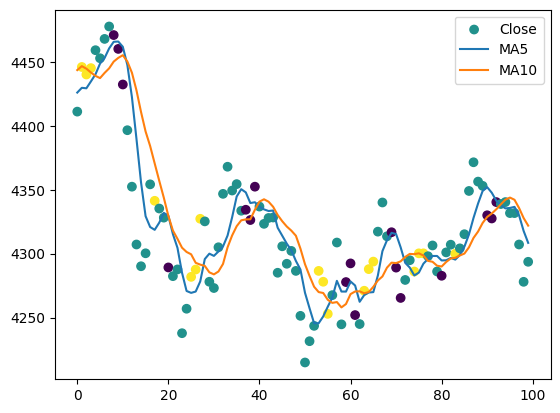

In [10]:
plt.scatter(range(100), handler.data['Close'][0:100], c=handler.data['Label'][0:100], label="Close")
plt.plot(range(100), handler.data[f'{ma_name}{ma1}'][0:100], label=f"{ma_name}{ma1}")
plt.plot(range(100), handler.data[f'{ma_name}{ma2}'][0:100], label=f"{ma_name}{ma2}")
plt.legend()
plt.show()

In [11]:
handler.data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,MA5,MA10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,Label,Kendall_5,Kendall_10,RSI,RSI_30-,RSI_BTW,RSI_70+,MACD,MACD_H,ADX14,+DM,-DM,OBV,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,LOG_RET,NTrades Var
35,1502973900000,4430.00,4431.13,4411.00,4411.00,0.846974,3.742259e+03,15,4425.884,4443.454,-0.002656,-0.000652,0.003374,0.007358,0,-0.4,-0.333333,52.780438,0,1,0,33.277807,-9.401686,36.390743,29.455046,23.285676,-0.014200,-0.071956,-0.114149,0.259602,-0.062045,-0.058502,-0.058620,-1.762928,-0.004553,-0.062500
36,1502974800000,4411.00,4445.88,4411.00,4445.88,1.258943,5.579008e+03,10,4429.600,4446.542,0.000840,0.000695,-0.003662,0.000149,1,0.0,-0.466667,58.370162,0,1,0,32.321404,-8.286472,34.856505,30.720371,20.989687,0.021412,0.105905,-0.028740,-0.118619,-0.042160,-0.098601,0.042958,-2.507813,0.007876,-0.333333
37,1502975700000,4430.43,4440.00,4422.60,4440.00,2.459375,1.088129e+04,14,4429.226,4444.542,-0.000084,-0.000450,-0.002427,0.001023,1,0.4,-0.422222,57.142128,0,1,0,30.734690,-7.898548,33.478103,28.687260,19.600564,-0.040951,-0.021039,-0.049092,-0.046814,-0.039545,-0.066181,-0.066181,-2.912572,-0.001323,0.400000
38,1502976600000,4435.12,4445.00,4425.21,4445.00,7.504640,3.333461e+04,41,4434.602,4441.562,0.001214,-0.000670,-0.002339,-0.000773,1,0.4,-0.200000,57.952230,0,1,0,29.540146,-7.274474,32.447500,28.491775,18.480857,0.130296,0.014177,-0.038866,-0.079011,-0.030784,-0.057126,-0.006814,-4.181738,0.001125,1.928571
39,1502977500000,4432.07,4459.00,4425.60,4459.00,20.089478,8.918173e+04,53,4440.176,4438.923,0.001257,-0.000594,-0.004222,-0.004503,0,0.6,0.155556,60.219594,0,1,0,29.384418,-5.944161,32.074396,29.754515,16.742491,0.308588,0.039125,-0.005272,-0.182874,-0.011499,-0.094063,0.044319,1.368353,0.003145,0.292683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193435,1677537900000,23397.31,23557.79,23390.54,23482.13,3276.986710,7.697566e+07,118924,23405.900,23366.460,0.000866,0.000960,-0.003246,-0.004926,0,0.6,0.866667,61.932773,0,1,0,0.601898,25.433536,24.975911,27.116201,18.390167,0.015035,0.147908,-1.057597,0.226309,-0.017551,-0.127108,0.434192,1.694754,0.003619,0.449533
193436,1677538800000,23481.28,23508.27,23448.20,23467.31,2209.161100,5.187482e+07,84221,23423.086,23388.653,0.000734,0.000950,-0.001884,-0.003352,0,0.6,0.822222,59.976988,0,1,0,8.071806,26.322756,24.561590,25.845527,17.528397,-0.009985,-0.031579,12.410594,0.034962,-0.016589,-0.046860,-0.046860,-1.664159,-0.000631,-0.291808
193437,1677539700000,23467.89,23525.88,23466.17,23490.51,1624.076700,3.816044e+07,74878,23443.360,23405.567,0.000866,0.000723,-0.002007,-0.003616,0,0.8,0.822222,62.000045,0,1,0,15.683025,27.147179,24.367283,26.019732,16.691128,0.007415,0.033731,0.942939,0.031320,-0.007911,-0.047766,0.006740,-1.742570,0.000988,-0.110934
193438,1677540600000,23491.18,23555.24,23480.79,23534.67,1677.606430,3.944878e+07,81570,23474.386,23425.349,0.001323,0.000845,-0.002561,-0.004645,0,0.8,0.822222,65.567754,0,1,0,24.990241,29.163517,24.498989,26.828370,15.685094,0.007603,0.057544,0.593458,0.074274,0.005405,-0.060274,0.031078,0.025357,0.001878,0.089372


In [12]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,NTrades Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_5,Kendall_10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5 UP,MA10 UP
0,1502973900000,-0.071956,-0.114149,0.259602,-0.062045,-0.058502,-0.058620,-1.762928,-0.062500,0,1,0,-0.004553,0,-0.4,-0.333333,-0.002656,-0.000652,0.003374,0.007358,0,1
1,1502974800000,0.105905,-0.028740,-0.118619,-0.042160,-0.098601,0.042958,-2.507813,-0.333333,0,1,0,0.007876,1,0.0,-0.466667,0.000840,0.000695,-0.003662,0.000149,0,1
2,1502975700000,-0.021039,-0.049092,-0.046814,-0.039545,-0.066181,-0.066181,-2.912572,0.400000,0,1,0,-0.001323,1,0.4,-0.422222,-0.000084,-0.000450,-0.002427,0.001023,0,1
3,1502976600000,0.014177,-0.038866,-0.079011,-0.030784,-0.057126,-0.006814,-4.181738,1.928571,0,1,0,0.001125,1,0.4,-0.200000,0.001214,-0.000670,-0.002339,-0.000773,0,1
4,1502977500000,0.039125,-0.005272,-0.182874,-0.011499,-0.094063,0.044319,1.368353,0.292683,0,1,0,0.003145,0,0.6,0.155556,0.001257,-0.000594,-0.004222,-0.004503,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193357,1677537900000,0.147908,-1.057597,0.226309,-0.017551,-0.127108,0.434192,1.694754,0.449533,0,1,0,0.003619,0,0.6,0.866667,0.000866,0.000960,-0.003246,-0.004926,1,0
193358,1677538800000,-0.031579,12.410594,0.034962,-0.016589,-0.046860,-0.046860,-1.664159,-0.291808,0,1,0,-0.000631,0,0.6,0.822222,0.000734,0.000950,-0.001884,-0.003352,1,0
193359,1677539700000,0.033731,0.942939,0.031320,-0.007911,-0.047766,0.006740,-1.742570,-0.110934,0,1,0,0.000988,0,0.8,0.822222,0.000866,0.000723,-0.002007,-0.003616,1,0
193360,1677540600000,0.057544,0.593458,0.074274,0.005405,-0.060274,0.031078,0.025357,0.089372,0,1,0,0.001878,0,0.8,0.822222,0.001323,0.000845,-0.002561,-0.004645,1,0


In [13]:
seq_length = 15
dataset = TSDataset(predict_data, seq_length)

In [14]:
train_indices = range(0, round(0.7 * len(dataset)), int(seq_length))
val_indices = range(round(0.7 * len(dataset)), round(0.9 * len(dataset)), int(seq_length))
test_indices = range(round(0.9 * len(dataset)), len(dataset) - seq_length)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices) # Validation set will be training set for Meta Labelling
test_set = torch.utils.data.Subset(dataset, test_indices)

In [15]:
label_distribution = (predict_data.loc[train_set.indices, 'Target'].value_counts() / predict_data.loc[train_set.indices, 'Target'].shape[0]).sort_index().to_list()
display(predict_data.loc[train_set.indices, 'Target'].value_counts())
label_distribution

Target
 0    6088
-1    1480
 1    1455
Name: count, dtype: int64

[0.1640252687576194, 0.6747201595921534, 0.1612545716502272]

In [16]:
class_weights = [1 / p for p in label_distribution]
print(class_weights)
weights = [class_weights[torch.argmax(label)] for _, label in train_set]
train_sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_set), replacement=True)
# train_sampler = None

[6.096621621621622, 1.482095926412615, 6.201374570446736]


In [17]:
input_size = dataset.size
hidden_size = 300
batch_size = 16
dynamic_batch = False
num_layers = 3
output_size = predict_data['Target'].unique().size
lstm_model = LSTMModel(input_size, hidden_size,
                       num_layers, output_size).to(device)

In [18]:
weights = torch.Tensor(label_distribution).to(device)
train_lstm(lstm_model, train_set, val_set, 30, 0.0001,
           batch_size, num_layers, hidden_size, device, train_sampler, class_weights=None, model_name=f'crossover_{seq_length}_to_{crossover_horizon}', save=True, dynamic_batch=False)

Epoch: 1/30 -- [8460/9023 (100.0%)]	Loss: 0.9559478768220184	Accuracy: 0.577	Time taken: 4.671875	Validation Loss: 1.1740950345993042 || Validation Accuracy: 0.338
Epoch: 2/30 -- [8460/9023 (100.0%)]	Loss: 0.8970254834028001	Accuracy: 0.646	Time taken: 4.671875	Validation Loss: 1.0358775854110718 || Validation Accuracy: 0.467
Epoch: 3/30 -- [8460/9023 (100.0%)]	Loss: 0.776240756114324	Accuracy: 0.771	Time taken: 4.578125	Validation Loss: 0.7926944494247437 || Validation Accuracy: 0.754
Epoch: 4/30 -- [8460/9023 (100.0%)]	Loss: 0.7321465983458445	Accuracy: 0.816	Time taken: 4.578125	Validation Loss: 0.8444634675979614 || Validation Accuracy: 0.696
Epoch: 5/30 -- [8460/9023 (100.0%)]	Loss: 0.7258629687923066	Accuracy: 0.820	Time taken: 4.546875	Validation Loss: 0.807594895362854 || Validation Accuracy: 0.735
Epoch: 6/30 -- [8460/9023 (100.0%)]	Loss: 0.72104264626689	Accuracy: 0.826	Time taken: 4.53125	Validation Loss: 0.7701172828674316 || Validation Accuracy: 0.775
Epoch: 7/30 -- [8460/

([0.9559478768220184,
  0.8970254834028001,
  0.776240756114324,
  0.7321465983458445,
  0.7258629687923066,
  0.72104264626689,
  0.7197737236183586,
  0.7168184688962098,
  0.7137311441255799,
  0.7174820902077019,
  0.7087944326459938,
  0.7067495101521201,
  0.7036986710331964,
  0.7015194253507235,
  0.7067073458898152,
  0.7047256062216792,
  0.7027006680872423,
  0.6949083180503642,
  0.7007402578989664,
  0.6943155694092419,
  0.6884775024356572,
  0.6952489265736114,
  0.6953910781559369,
  0.6927633569807026,
  0.6834208798323963,
  0.6896898220194146,
  0.6889216627212281,
  0.6855467813657531,
  0.6765873539955058,
  0.6802157743814143],
 [0.5769699656433559,
  0.6462373933281613,
  0.7705862795079242,
  0.8158040563005652,
  0.8200155159038014,
  0.8260002216557686,
  0.8284384351102737,
  0.8295467139532307,
  0.8340906572093538,
  0.8287709187631608,
  0.837969633159703,
  0.8418486091100521,
  0.8456167571761055,
  0.8460600687132883,
  0.8410728139199822,
  0.844508478

In [19]:
eval_lstm(lstm_model, test_set, 256, num_layers, hidden_size, device)

Accuracy : 0.7689958592132505 || Loss : 0.7772314548492432
Confusion matrix : 
[[2.549e+03 4.830e+02 0.000e+00]
 [1.529e+03 9.536e+03 2.192e+03]
 [1.000e+00 2.580e+02 2.772e+03]]


(tensor([[9.9994e-01, 5.5302e-05, 1.7818e-14],
         [9.9910e-01, 9.0408e-04, 1.5210e-11],
         [8.2396e-14, 6.3089e-04, 9.9937e-01],
         ...,
         [6.6738e-15, 1.8789e-05, 9.9998e-01],
         [9.9971e-01, 2.8546e-04, 1.5800e-13],
         [9.9998e-01, 2.1122e-05, 7.0275e-16]], device='cuda:0',
        grad_fn=<CatBackward0>),
 tensor([[1., 0., 0.],
         [1., 0., 0.],
         [0., 1., 0.],
         ...,
         [0., 0., 1.],
         [1., 0., 0.],
         [1., 0., 0.]], device='cuda:0'))